<a href="https://colab.research.google.com/github/MetronWard/hands_on_ml/blob/main/X_Ray_Pneumonia_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initializing Kaggle

In [1]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

# Downloading Data

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --force

 99% 2.28G/2.29G [00:13<00:00, 269MB/s]
100% 2.29G/2.29G [00:13<00:00, 183MB/s]


In [5]:
from zipfile import ZipFile
ZIP_FILE_PATH = "/content/chest-xray-pneumonia.zip"
import os

def extract_data(filepath=ZIP_FILE_PATH):
  file = ZipFile(file=filepath)
  file.extractall()
  file.close()
  os.remove(filepath)

In [6]:
extract_data()

In [7]:
from pathlib import Path
import shutil

# Deleting excess folders

FOLDER_PATH = "/content/chest_xray"
for item in os.listdir(FOLDER_PATH):
  if item != "chest_xray":
    path = Path(FOLDER_PATH, item)
    shutil.rmtree(path)

# Visualizing Data

In [8]:
from typing import Literal
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import random

FILEPATH = "/content/chest_xray/chest_xray/train"
TYPES = Literal["normal", "pneumonia"]
def plot_random_images(filepath=FILEPATH, types:TYPES="normal"):
  path = Path(filepath, types.upper())
  for folder_name, sub_folders, file_names in os.walk(path):
    choice = Path(path, random.choice(file_names))
  random_image = mimg.imread(choice)
  plt.imshow(random_image, cmap=plt.cm.binary_r)
  plt.title(types)
  plt.axis(False)
  print(f"The image has dimensions {random_image.shape}\n\n")

The image has dimensions (1318, 1472)




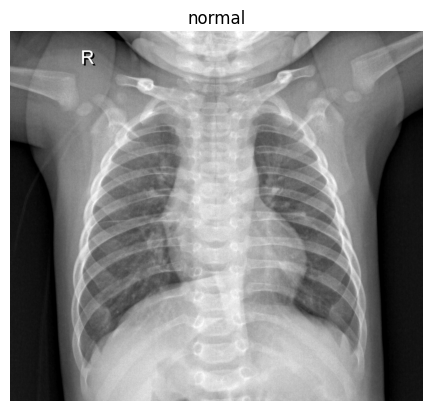

In [9]:
plot_random_images(types="normal")

The image has dimensions (1295, 1778)




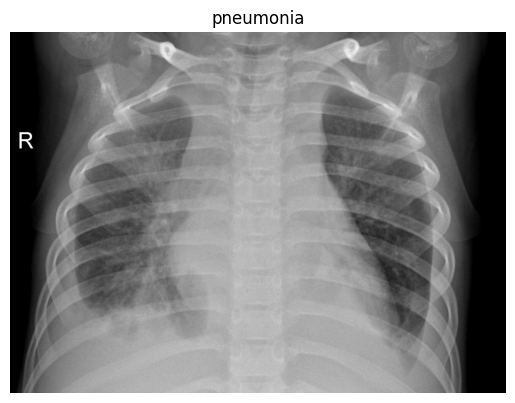

In [10]:
plot_random_images(types="pneumonia")

# Developing a simple model

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam

## Data Generators

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_dir = "/content/chest_xray/chest_xray/train"
test_dir = "/content/chest_xray/chest_xray/test"
val_dir = "/content/chest_xray/chest_xray/val"

train_data = train_datagen.flow_from_directory(train_dir, batch_size=32,
                                               target_size=(224, 224), class_mode="binary",
                                               seed=42)

test_data = train_datagen.flow_from_directory(test_dir, batch_size=32,
                                               target_size=(224, 224), class_mode="binary",
                                               seed=42)

val_data = train_datagen.flow_from_directory(val_dir, batch_size=32,
                                               target_size=(224, 224), class_mode="binary",
                                               seed=42)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Baseline Model

In [18]:
base_model = Sequential([
  Conv2D(filters=5,kernel_size=3,strides=1,
         padding="valid", activation="relu",
         input_shape=(224, 224, 3)),
  Conv2D(5, 3, activation="relu"),
  MaxPool2D(pool_size=2, padding="valid"),
  Flatten(),
  Dense(1, activation="sigmoid")
])

In [19]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 5)       140       
                                                                 
 conv2d_3 (Conv2D)           (None, 220, 220, 5)       230       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 110, 110, 5)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 60500)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 60501     
                                                                 
Total params: 60871 (237.78 KB)
Trainable params: 60871 (237.78 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [20]:
base_model.compile(loss=keras.losses.BinaryCrossentropy(),
                   optimizer=Adam(),
                   metrics=["accuracy"])

base_history = base_model.fit(train_data, epochs=4, steps_per_epoch=len(train_data),
               validation_data = val_data, validation_steps=len(val_data), verbose=0)

Epoch 1/4
163/163 [==============================] - 48s 282ms/step - loss: 0.3444 - accuracy: 0.8777 - val_loss: 0.2109 - val_accuracy: 0.9375
Epoch 2/4
163/163 [==============================] - 46s 284ms/step - loss: 0.1255 - accuracy: 0.9502 - val_loss: 0.2410 - val_accuracy: 0.9375
Epoch 3/4
163/163 [==============================] - 48s 295ms/step - loss: 0.0849 - accuracy: 0.9697 - val_loss: 0.0789 - val_accuracy: 1.0000
Epoch 4/4
163/163 [==============================] - 47s 288ms/step - loss: 0.0731 - accuracy: 0.9724 - val_loss: 0.0857 - val_accuracy: 1.0000


## Visualizing Progress

In [22]:
import pandas as pd

hs = pd.DataFrame(base_history.history)

<Axes: >

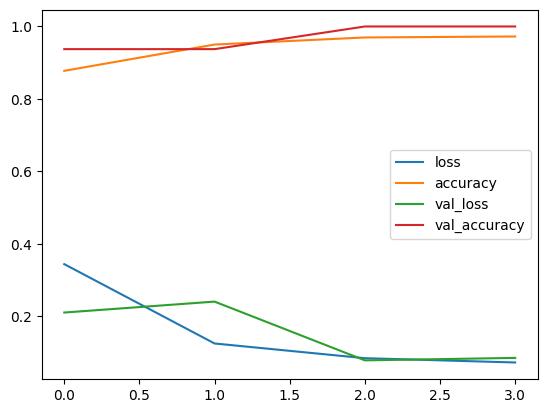

In [23]:
hs.plot()

In [26]:
def plot_progress(model_history):
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  accuracy = model_history.history['accuracy']
  val_accuracy = model_history.history['val_accuracy']

  epochs = range(len(model_history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

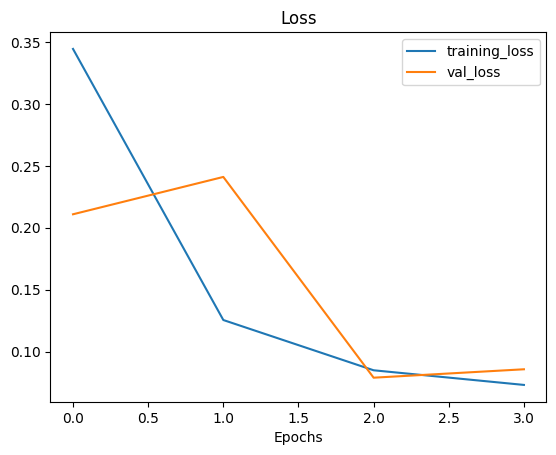

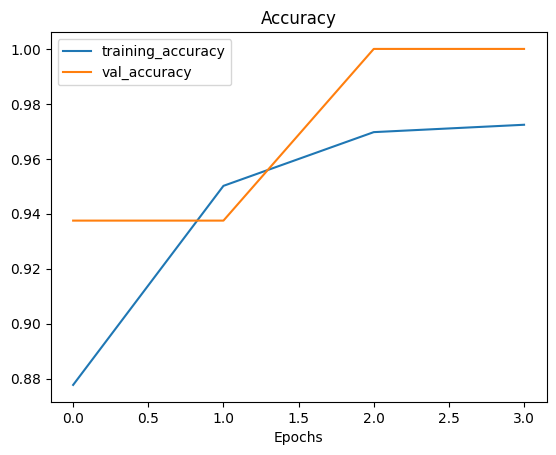

In [27]:
plot_progress(base_history)

# Evualuation

In [21]:
base_model.evaluate(test_data)

20/20 [==============================] - 5s 223ms/step - loss: 0.4653 - accuracy: 0.8221


[0.46525079011917114, 0.8221153616905212]